# Simple CNN with TensorFlow — MNIST Example

This notebook demonstrates the basics of building, training, and evaluating a **Convolutional Neural Network (CNN)** using **TensorFlow 2 / Keras** on the **MNIST** handwritten digits dataset.

**What you'll see:**
- Loading and preparing the MNIST dataset
- Building a simple CNN (Conv -> Pool -> Conv -> Pool -> Dense)
- Training and evaluating the model
- Visualizing some predictions

All code lines include documentation comments explaining what each line does.


In [1]:
#!pip install tensorflow

In [2]:
#!pip install matplotlib

In [3]:
# Imports and TensorFlow version check
# We import tensorflow (tf), numpy, and matplotlib for plotting.
import tensorflow as tf  # Core TensorFlow library (includes Keras)
import numpy as np       # Numerical computing helper
import matplotlib.pyplot as plt  # Plotting images and metrics in the notebook

# Print TensorFlow version to ensure TF2.x is available
print('TensorFlow version:', tf.__version__)

# For reproducibility (not strictly required):
tf.random.set_seed(42)
np.random.seed(42)


2025-11-02 08:03:54.003295: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2


In [4]:
# Load MNIST dataset (handwritten digits 0-9)
# Keras provides convenient dataset loaders; MNIST contains 28x28 grayscale images.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Inspect shapes
print('x_train shape:', x_train.shape)  # (60000, 28, 28)
print('y_train shape:', y_train.shape)  # (60000,)

# Normalize pixel values to [0,1] range and reshape to add channel dimension
# Convolutional layers expect input shape (height, width, channels)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a channel dimension (grayscale -> channel=1)
x_train = x_train[..., np.newaxis]  # shape becomes (60000, 28, 28, 1)
x_test = x_test[..., np.newaxis]    # shape becomes (10000, 28, 28, 1)

print('After reshape x_train shape:', x_train.shape)


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
After reshape x_train shape: (60000, 28, 28, 1)


In [5]:
# Build a simple CNN using Keras Sequential API
from tensorflow.keras import layers, models, optimizers, losses, metrics

# Define the model as a sequence of layers
model = models.Sequential([
    # First convolutional block: Conv2D -> ReLU activation -> MaxPooling
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), name='conv1'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool1'),

    # Second convolutional block
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='conv2'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool2'),

    # Flatten the 2D feature maps into a 1D vector to feed into Dense layers
    layers.Flatten(name='flatten'),

    # Fully connected (dense) layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu', name='dense1'),

    # Output layer with 10 units (for 10 classes) and softmax activation to get probabilities
    layers.Dense(10, activation='softmax', name='predictions')
])

# Show the model architecture summary
model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the model
# - optimizer: controls the update rule for weights      (we use Adam, a popular choice)
# - loss: the objective function to minimize             (suitable loss for multi-class classification)
# - metrics: metrics to report during training/testing   (accuracy is common for classification)
model.compile(
    optimizer=optimizers.Adam(),                     # Adam optimizer
    loss=losses.SparseCategoricalCrossentropy(),     # Sparse categorical crossentropy for integer labels
    metrics=[metrics.SparseCategoricalAccuracy()]    # Track accuracy (works with sparse labels)
)


In [7]:
# Train the model
# - epochs: number of full passes over the training data
# - batch_size: number of samples per gradient update
# - validation_split: fraction of training data held out for validation
history = model.fit(
    x_train, y_train,
    epochs=5,            # small number for quick demonstration; increase for better performance
    batch_size=128,
    validation_split=0.1, # 10% of training set used for validation
    verbose=2
)


Epoch 1/5
422/422 - 47s - 111ms/step - loss: 0.2187 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.0633 - val_sparse_categorical_accuracy: 0.9842
Epoch 2/5
422/422 - 46s - 109ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.0475 - val_sparse_categorical_accuracy: 0.9870
Epoch 3/5
422/422 - 45s - 106ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.9895
Epoch 4/5
422/422 - 46s - 109ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9898
Epoch 5/5
422/422 - 44s - 103ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9931 - val_loss: 0.0430 - val_sparse_categorical_accuracy: 0.9885


In [8]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {test_loss:.4f}  |  Test accuracy: {test_accuracy:.4f}')


313/313 - 2s - 6ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9890
Test loss: 0.0341  |  Test accuracy: 0.9890


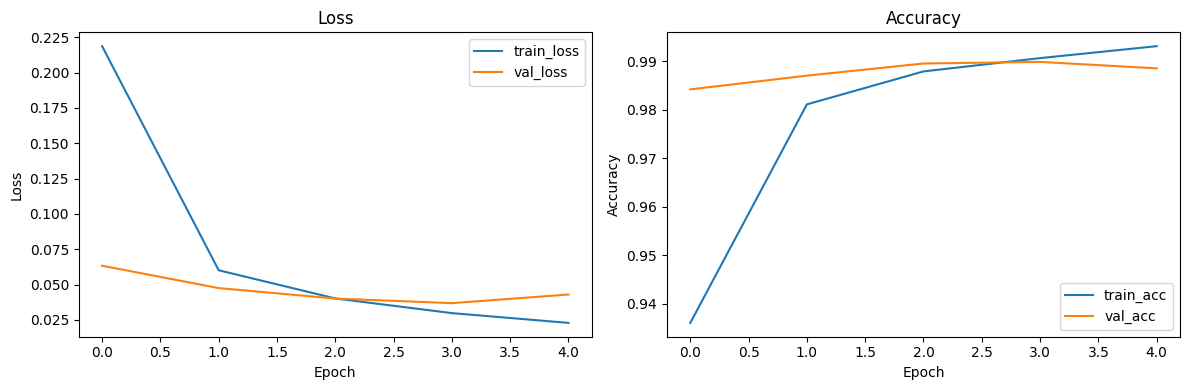

In [9]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12,4))

# Loss plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'], label='train_acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


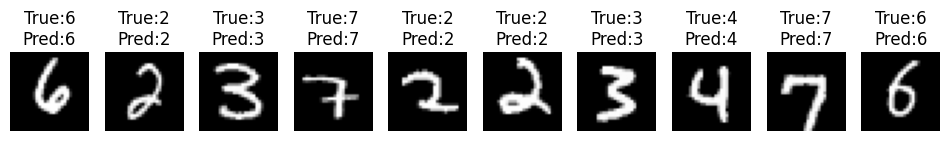

In [10]:
# Display some test images with predicted labels
num_images = 10
indices = np.random.choice(len(x_test), num_images, replace=False)
preds = model.predict(x_test[indices])
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(12,3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f'True:{y_test[idx]}\nPred:{pred_labels[i]}')
    plt.axis('off')
plt.show()
